### GA4 데이터로 프로덕트 분석
- 출처: kaggle, Google Analytics Customer Revenue Prediction
https://www.kaggle.com/competitions/ga-customer-revenue-prediction/data?select=train.csv


In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import numpy as np
import json

In [2]:
# 파일 불러오기
df_origin = pd.read_csv('D:/2024 내일배움캠프/phython/A06_team_project/train.csv', encoding='utf-8')
df_origin.info()

C:\Users\dkf22\AppData\Local\Temp\ipykernel_17964\959461698.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_origin = pd.read_csv('D:/2024 내일배움캠프/phython/A06_team_project/train.csv', encoding='utf-8')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   channelGrouping       903653 non-null  object
 1   date                  903653 non-null  int64 
 2   device                903653 non-null  object
 3   fullVisitorId         903653 non-null  object
 4   geoNetwork            903653 non-null  object
 5   sessionId             903653 non-null  object
 6   socialEngagementType  903653 non-null  object
 7   totals                903653 non-null  object
 8   trafficSource         903653 non-null  object
 9   visitId               903653 non-null  int64 
 10  visitNumber           903653 non-null  int64 
 11  visitStartTime        903653 non-null  int64 
dtypes: int64(4), object(8)
memory usage: 82.7+ MB


In [3]:
# 딕셔너리 모양 문자열 칼럼 데이터프레임으로 만들기 
def get_columns(columns_list: list):
    """" 딕셔너리 모양으로 들어간 문자열 칼럼을 데이터 프레임으로 변환해주는 함수  
    Args:
        columns_list(list): df_origin(pd.DataFrame)에서 변환이 필요한 칼럼명 리스트 

    Returns:
        pd.DataFrame: 데이터프레임
    """""
    df = df_origin.copy()

    for col in columns_list:
        change_df = pd.json_normalize(json.loads(row) for row in list(df[col]))
        change_df.columns = [f'{col}.{subcol}' for subcol in change_df.columns]
        df = df.drop(col, axis=1)
        df = pd.concat([df, change_df], axis = 1)
    return df

json_columns = ['device', 'geoNetwork', 'totals', 'trafficSource']
df = get_columns(json_columns)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 55 columns):
 #   Column                                             Non-Null Count   Dtype 
---  ------                                             --------------   ----- 
 0   channelGrouping                                    903653 non-null  object
 1   date                                               903653 non-null  int64 
 2   fullVisitorId                                      903653 non-null  object
 3   sessionId                                          903653 non-null  object
 4   socialEngagementType                               903653 non-null  object
 5   visitId                                            903653 non-null  int64 
 6   visitNumber                                        903653 non-null  int64 
 7   visitStartTime                                     903653 non-null  int64 
 8   device.browser                                     903653 non-null  object
 9   devi

In [4]:
# 불필요한 칼럼 삭제(분석 칼럼 22개)
df = df[['channelGrouping','date','fullVisitorId', 'visitNumber',\
          'visitStartTime', 'device.isMobile','device.deviceCategory', 'geoNetwork.continent', \
          'geoNetwork.country', 'totals.visits','totals.hits', 'totals.pageviews', \
          'totals.bounces', 'totals.newVisits', 'totals.transactionRevenue', 'trafficSource.campaign',\
          'trafficSource.source', 'trafficSource.medium','trafficSource.keyword', 'trafficSource.isTrueDirect',\
          'trafficSource.adwordsClickInfo.slot','trafficSource.adwordsClickInfo.adNetworkType']]

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 22 columns):
 #   Column                                        Non-Null Count   Dtype 
---  ------                                        --------------   ----- 
 0   channelGrouping                               903653 non-null  object
 1   date                                          903653 non-null  int64 
 2   fullVisitorId                                 903653 non-null  object
 3   visitNumber                                   903653 non-null  int64 
 4   visitStartTime                                903653 non-null  int64 
 5   device.isMobile                               903653 non-null  bool  
 6   device.deviceCategory                         903653 non-null  object
 7   geoNetwork.continent                          903653 non-null  object
 8   geoNetwork.country                            903653 non-null  object
 9   totals.visits                                 903653 non-nu

데이터 타입

In [5]:
# 문자열로 변환: 'date','fullVisitorId','visitId','visitNumber','visitStartTime' 
df = df.astype({'date':'str', 'fullVisitorId':'str', 'visitNumber':'str'})

# 정수형으로 변환: 'totals.visits','totals.hits','totals.pageviews','totals.bounces','totals.newVisits','totals.transactionRevenue'
# astype으로 변경 시 'totals.pageviews' 에러(float NaN) 발생하여 to_numeric으로 조정 
numberic_list = ['totals.visits','totals.hits','totals.pageviews','totals.bounces','totals.newVisits','totals.transactionRevenue'] 

for num_col in numberic_list:
    df[num_col] = pd.to_numeric(df[num_col], errors='coerce') #coerce는 오류 발견시 NaN으로 변경

# totals_transactionRevenue 금액 조정 
# GA상 매출액 10^6 값으로 표기 (ex. 2.4는 2400000로)
df['totals.transactionRevenue'] = (df['totals.transactionRevenue']**(1/6)).round(2)

In [6]:
# 매출 여부에 따른 칼럼 추가
def get_binary(x: int):
    """
    값이 있으면 1, 없으면 0을 변환하는 함수

    Args:
        x (int): 변환할 데이터 값으로 이외의 데이터 타입이 올 수 있음
    Returns:
        int: 값이 있으면 1, 없으면 0을 변환
    """
    if x > 0:
        return 1
    else:
        return 0
        
df['Revenue_yn'] = df['totals.transactionRevenue'].apply(get_binary)
df['Revenue_yn'].value_counts()

Revenue_yn
0    892138
1     11515
Name: count, dtype: int64

In [7]:
# datetime으로 변환: 'date' (str > int > datetime)
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')
df['visitStartTime'] = pd.to_datetime(df['visitStartTime'], unit='s')

df.describe(include='all')

,channelGrouping,date,fullVisitorId,visitNumber,visitStartTime,device.isMobile,device.deviceCategory,geoNetwork.continent,geoNetwork.country,totals.visits,...,totals.newVisits,totals.transactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.isTrueDirect,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.adNetworkType,Revenue_yn
count,903653,903653,903653,903653,903653,903653,903653,903653,903653,903653.0,...,703060.0,11515.000000,903653,903653,903653,400724,274005,21460,21460,903653.000000
unique,8,NaN,716924,384,NaN,2,3,6,222,NaN,...,NaN,NaN,10,380,7,3659,1,2,2,NaN
top,Organic Search,NaN,1957458976293878100,1,NaN,False,desktop,Americas,United States,NaN,...,NaN,NaN,(not set),google,organic,(not provided),True,Top,Google Search,NaN
freq,381561,NaN,278,703060,NaN,664530,664479,450377,364744,NaN,...,NaN,NaN,865347,400788,381561,366363,274005,20956,21453,NaN
mean,NaN,2017-01-20 18:54:58.635206400,NaN,NaN,2017-01-21 14:01:30.059528448,NaN,NaN,NaN,NaN,1.0,...,1.0,19.908796,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.012743
min,NaN,2016-08-01 00:00:00,NaN,NaN,2016-08-01 07:00:12,NaN,NaN,NaN,NaN,1.0,...,1.0,4.640000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
25%,NaN,2016-10-27 00:00:00,NaN,NaN,2016-10-27 09:39:29,NaN,NaN,NaN,NaN,1.0,...,1.0,17.090000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
50%,NaN,2017-01-09 00:00:00,NaN,NaN,2017-01-09 08:02:14,NaN,NaN,NaN,NaN,1.0,...,1.0,19.160000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
75%,NaN,2017-04-21 00:00:00,NaN,NaN,2017-04-21 07:12:42,NaN,NaN,NaN,NaN,1.0,...,1.0,21.810000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
max,NaN,2017-08-01 00:00:00,NaN,NaN,2017-08-02 06:59:53,NaN,NaN,NaN,NaN,1.0,...,1.0,53.380000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 23 columns):
 #   Column                                        Non-Null Count   Dtype         
---  ------                                        --------------   -----         
 0   channelGrouping                               903653 non-null  object        
 1   date                                          903653 non-null  datetime64[ns]
 2   fullVisitorId                                 903653 non-null  object        
 3   visitNumber                                   903653 non-null  object        
 4   visitStartTime                                903653 non-null  datetime64[ns]
 5   device.isMobile                               903653 non-null  bool          
 6   device.deviceCategory                         903653 non-null  object        
 7   geoNetwork.continent                          903653 non-null  object        
 8   geoNetwork.country                            903653 n

In [30]:
# 날짜데이터 년/월/일/년월/주로 정리 
############ visitStartTime 기준으로 할지 협의 필요 
import datetime as dt 

visit_year = df['date'].dt.year
visit_month = df['date'].dt.month
visit_year_month = df['date'].dt.strftime('%Y-%m')
visit_day = df['date'].dt.day
visit_weekday = df['date'].dt.weekday # 월요일이 0 
visit_week = df['date'].dt.strftime('%Y-%W') #몇번째주차인지

# 날짜별로 유저수, 구매건수 확인 
main_variable = ['fullVisitorId', 'totals.bounces','totals.transactionRevenue']

cnt_by_year_month = df.groupby([visit_year_month])[main_variable].count()
cvr_by_year_mont =  (cnt_by_year_month['totals.transactionRevenue'] / cnt_by_year_month['fullVisitorId'])*100
bounce_rate_by_year_mont = (cnt_by_year_month['totals.bounces'] / cnt_by_year_month['fullVisitorId'])*100

display(cnt_by_year_month)
display(cvr_by_year_mont)
display(bounce_rate_by_year_mont)


,fullVisitorId,totals.bounces,totals.transactionRevenue
date,,,
2016-08,74759,36585,1119
2016-09,71032,34808,859
2016-10,97506,52613,872
2016-11,113972,57519,919
2016-12,79124,35495,1395
2017-01,64694,31326,697
2017-02,62192,31279,708
2017-03,69931,35916,883
2017-04,67126,34535,928


date
2016-08    1.496810
2016-09    1.209314
2016-10    0.894304
2016-11    0.806338
2016-12    1.763055
2017-01    1.077380
2017-02    1.138410
2017-03    1.262673
2017-04    1.382475
2017-05    1.705649
2017-06    1.487936
2017-07    1.435693
2017-08    1.682316
dtype: float64

date
2016-08    48.937252
2016-09    49.003266
2016-10    53.958731
2016-11    50.467659
2016-12    44.859967
2017-01    48.421801
2017-02    50.294250
2017-03    51.359197
2017-04    51.448023
2017-05    47.735234
2017-06    49.864733
2017-07    50.699048
2017-08    48.435055
dtype: float64

Text(0.5, 1.0, 'total user count by week')

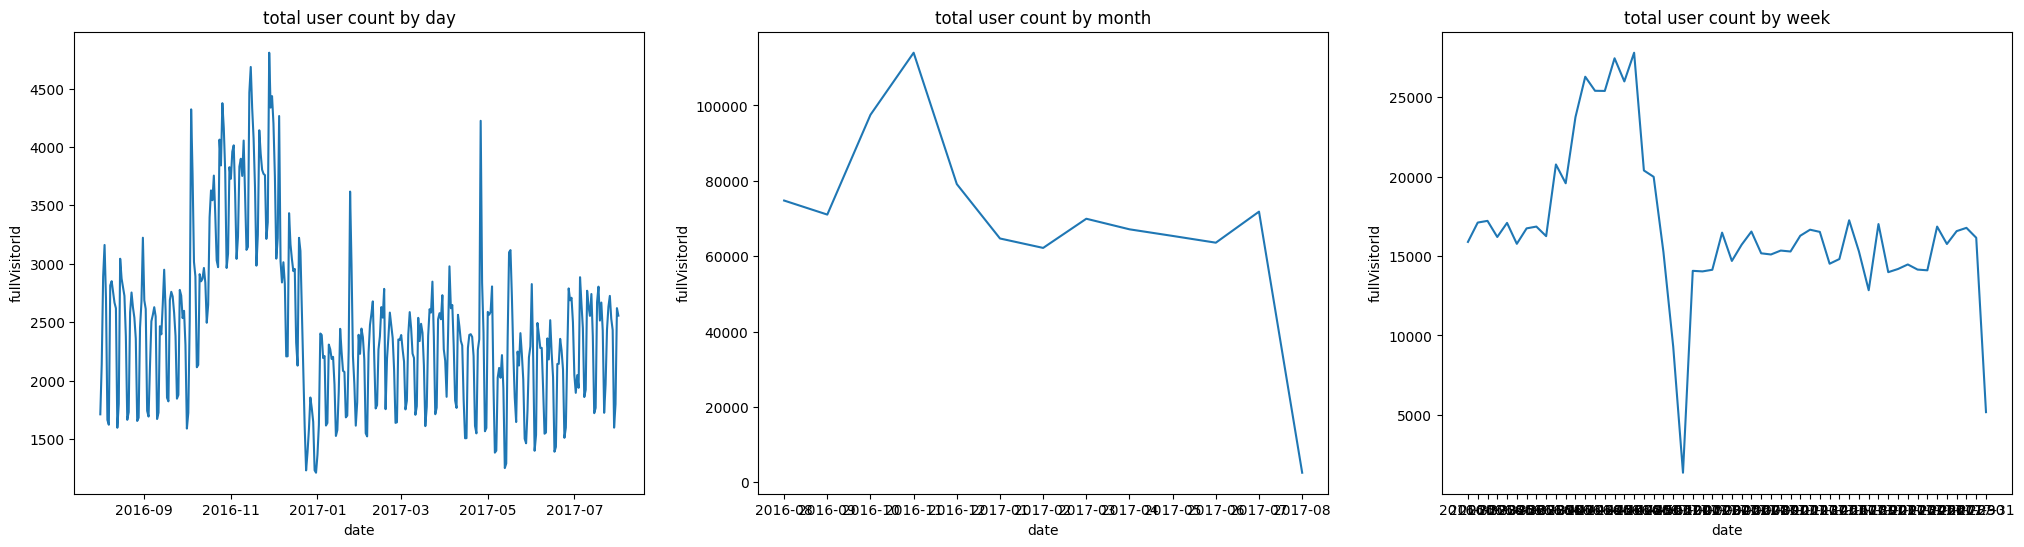

In [32]:
dau_by_date = df.groupby(df['date'])['fullVisitorId'].count()
mau_by_date = df.groupby(visit_year_month)['fullVisitorId'].count()
wau_by_date = df.groupby(visit_week)['fullVisitorId'].count()

plt.figure(figsize= (25,6))
plt.subplot(1, 3, 1)
sns.lineplot(data=dau_by_date)
plt.title('total user count by day')
plt.subplot(1, 3, 2)
sns.lineplot(data=mau_by_date)
plt.title('total user count by month')
plt.subplot(1, 3, 3)
sns.lineplot(data=wau_by_date)
plt.title('total user count by week')

In [33]:
# 채널별 월별 유저수 추이
pd.DataFrame( df.groupby(['channelGrouping', visit_year_month])['fullVisitorId'].count()).unstack()


fullVisitorId                                               \
date                  2016-08  2016-09  2016-10  2016-11  2016-12  2017-01   
channelGrouping                                                              
(Other)                   2.0      3.0      NaN      1.0      NaN      6.0   
Affiliates             1909.0   1352.0   1133.0   1306.0    942.0   1243.0   
Direct                12163.0   9281.0   9376.0  11529.0  14248.0  13381.0   
Display                 449.0    416.0    580.0    686.0    827.0    660.0   
Organic Search        24143.0  25637.0  33299.0  32039.0  32008.0  28769.0   
Paid Search            1467.0   1589.0   1942.0   2447.0   3631.0   2533.0   
Referral               9254.0   8027.0   9082.0   8746.0  10898.0   7648.0   
Social                25372.0  24727.0  42094.0  57218.0  16570.0  10454.0   

                                                                               
date             2017-02  2017-03  2017-04  2017-05  2017-06  2017-07 2017-08  
channelGrouping                                                                
(Other)              NaN      4.0     98.0      5.0      NaN      1.0     NaN  
Affiliates        1214.0   1468.0   1366.0   1317.0   1313.0   1788.0    52.0  
Direct           10386.0  11246.0  12658.0  15599.0  10453.0  12306.0   400.0  
Display            526.0    411.0    209.0    427.0    342.0    690.0    39.0  
Organic Search   30332.0  34960.0  32345.0  33199.0  35829.0  37655.0  1346.0  
Paid Search       2046.0   1240.0   1189.0   1887.0   3180.0   2105.0    70.0  
Referral          6935.0   7650.0   7786.0   9251.0   9607.0   9518.0   436.0  
Social           10753.0  12952.0  11475.0   3686.0   2854.0   7749.0   213.0